Consider the system 
$$\left\{\begin{array}{l}
S'=-u\beta SI\\
I'=u\beta SI-\nu I\\
R'=\nu I\\
S(t_0)=1-I_0,I(t_0)=\frac{I_0}{N},R(t_0)=0
\end{array}\right.$$
where $S_0+I_0+R_0=1$.

The goal is to solve the optimal control proplem
$$\inf\limits_{u\in\mathcal{U}}J(u)$$
where 
$$
J(u)=S(T)+I(T)-\frac{\nu}{\beta}\ln S(T),
$$
 and
$$\mathcal{U}=\{u\in L^{\infty}(0,T):\alpha\leqslant u\leqslant 1\}$$

One has 
$$
DJ(u)\cdot h=\beta\int_0^TSI(P_I-P_S)h,
$$
where
\begin{equation*}
\left\{\begin{array}{l}
 -\frac{d }{d t}\begin{pmatrix} P_S \\ P_I \end{pmatrix} = \begin{pmatrix}-u\beta I & u\beta I\\ -u\beta S & u\beta S-\nu \end{pmatrix}\begin{pmatrix}P_S \\ P_I \end{pmatrix},\\
P_S(T)=1-\frac{\nu}{\beta S(T)}, \ P_I(T)=1
\end{array}\right.
\end{equation*}


In [1]:
from __future__ import division
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Parameters of the model
beta=0.29
nu=0.1
t0=0
alpha_conf = 0.231

# state initialization 
N=6.7e7
I0=1000/N
S0=1-I0
R0=0
init=np.array([S0, I0,0.0]) 


In [5]:

def f(u,y):
	dy = np.array([-u*beta*y[0]*y[1],u*beta*y[0]*y[1]-nu*y[1],nu*y[1]])
	return dy

def RK4_state(u,init):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	w = np.zeros((NT,3))
	w[0,:] = init    #initial conditions
	for i in range(NT-1):
		k1 = h*f(u[i], w[i,:])
		k2 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k1)
		k3 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k2) 
		k4 = h*f(u[i+1], w[i,:]+k3)
		w[i+1,:] = w[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return w

def f_dual(i,u_i,ystate,p_i):
	a11=-beta*u_i*ystate[i,1]
	a12=-beta*u_i*ystate[i,0]
	a21=beta*u_i*ystate[i,1]
	a22=beta*u_i*ystate[i,0]-nu
	A=np.matrix([[a11, a12],[a21 ,a22]])
	return np.transpose(np.transpose(A)*np.transpose(np.matrix(p_i)))

def RK4_adj(u,ystate):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	pT = np.zeros((NT,2))
	pT[-1,:] = np.array([1-nu/(beta*ystate[-1,0]), 1])
	for i in list(reversed(range(1,NT))):
		k1 = h*f_dual(i,u[i],ystate,pT[i,:])
		k2 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k1)
		k3 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k2) 
		k4 = h*f_dual(i,u[i-1],ystate,pT[i,:]+k3)
		pT[i-1,:] = pT[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return pT

def J(y):
    return y[-1,0]+y[-1,1]-(nu/beta)*np.log(y[-1,0])

def DJ(y,p):
    return beta*y[:,1]*y[:,0]*(p[:,1]-p[:,0])

def DJ_finite_dim(y,p,T0):
    nT0 = int(T0*NT/T)-1
    return (1-alpha)*beta*y[nT0,1]*y[nT0,0]*(p[nT0,1]-p[nT0,0])

def func_dicho(T0,init):
    u=np.ones(int(NT))
    for i in range(int(T0*NT/T),int(NT)):
        u[i]=alpha
    yval=RK4_state(u,init)
    return J(yval)

def Dicho(fun,a,b):
        xx = [] #liste
        Jval = [] #liste
        x0 = a # borne gauche de l'intervalle initial
        x1 = b # borne gauche de l'intervalle initial b>a
        xx.append((x0+x1)/2) # ajouter a une liste
        compteur = 0
        while ((x1-x0)>1e-10 and compteur<100):
                xt0=x0+1/3*(x1-x0)
                xt1=x0+2/3*(x1-x0)
                M0=fun(xt0,init)
                M1=fun(xt1,init)
                if M0 < M1:
                        x1=xt1
                else:
                        x0=xt0
                xx.append((x0+x1)/2) # ajouter a une liste
                Jval.append(fun((x0+x1)/2,init)) # ajouter a une liste
                compteur=compteur+1
        if (compteur==1000):
                print("Nombre maximal d'iterations atteint")
        print("Nombre d'iterations : ",compteur)
        xopt=(x0+x1)/2
        print(u"le minimiseur trouv\u00e9 est x=",xopt)
        xx = np.array(xx) # transforme une liste en tableau
        return xx, Jval;
    

def Dicho_S_inf(val):
    xx = [] #liste
    x0 = 0.0 # borne gauche de l'intervalle initial
    x1 = nu/beta # borne gauche de l'intervalle initial b>a
    xx.append((x0+x1)/2) # ajouter a une liste
    compteur = 0
    M0 = x0-(nu/beta)*np.log(x0)
    M1 = x1-(nu/beta)*np.log(x1)
    print('J(S_inf_min)',M1)
    print('J(S_inf_max)',M0)
    print('val',val)
    while ((x1-x0)>1e-10 and compteur<100):
            xt0=x0+1/2*(x1-x0)
            Mt0=xt0-(nu/beta)*np.log(xt0)
            if Mt0 > val:
                    x0=xt0
            else:
                    x1=xt0
            xx.append((x0+x1)/2) # ajouter a une liste
            compteur=compteur+1

    if (compteur==1000):
            print("Nombre maximal d'iterations atteint")
    print("Nombre d'iterations : ",compteur)

    xopt=(x0+x1)/2

    print("le minimiseur trouv\u00e9 est x=",xopt)
    print("pour une valeur de ",xopt-(nu/beta)*np.log(xopt))

    xx = np.array(xx) # transforme une liste en tableau
    return xx;

def optimSIR(uinit,init):
	u=uinit
	yval=RK4_state(u,init)
	pval=RK4_adj(u,yval)
	Jnew=J(yval)
	Jval = [Jnew]
	Delta2=1
	i=0
	rho=1000 # pas dans la methode de gradient
	while (abs(Delta2)>1e-10) and (i<ITER):
		print('i=',i,'and J=',Jnew,'rho=',rho)          
		rho=100*rho#np.minimum(100*rho,1000.0)
		yval=RK4_state(u,init)
		pval=RK4_adj(u,yval)
		Delta=1
		k1=0
		while (Delta>0) and (k1<100): # recherche du pas
			rho=rho/1.2
			utest=u-rho*DJ(yval,pval)
			utest=np.maximum(alpha,np.minimum(utest,1))
			yval_test=RK4_state(utest,init)
			Jnew=J(yval_test)
			Delta=Jnew-Jval[-1]
			k1=k1+1
		k2=0
		utest2=utest
		Jnew2=Jnew
		Delta=-1
		while (Delta<0) and (k2<100): # recherche du pas
			rho=rho/1.2
			Jnew1=Jnew2     
			utest1=utest2 
			utest2=u-rho*DJ(yval,pval)
			utest2=np.maximum(alpha,np.minimum(utest2,1))
			yval_test=RK4_state(utest2,init)
			Jnew2=J(yval_test)
			Delta=Jnew2-Jnew1
			k2=k2+1
		Delta1=Jnew-Jval[-1]
		Delta2=Jnew1-Jval[-1]
		print('k1=',k1,'k2=',k2,'Delta1',Delta1,'Delta2',Delta2)            
		u=np.copy(utest1)
		Jval.append(Jnew1)
		i=i+1
	if (i==iter):
		print('maximal number of iterations reached')
	print('end of computations')
	return u, i, Jnew, Jval, yval


def optimSIR_finite_dim(T0init,init,rho):
	T0 = T0init
	u=np.ones(int(NT))
	for i in range(int(T0*NT/T),int(NT)):
		u[i]=alpha
	yval=RK4_state(u,init)
	pval=RK4_adj(u,yval)
	Jnew=J(yval)
	Jval = [Jnew]
	Delta2=1
	i=0
	#rho=10000#0.5*T # pas dans la methode de gradient
	while (abs(Delta2)>1e-10) and (i<ITER):
		print('i=',i,'and J=',Jnew,'rho=',rho)          
		rho=np.minimum(100*rho,10000)
		yval=RK4_state(u,init)
		pval=RK4_adj(u,yval)
		Delta=1
		k1=0
		while (Delta>0) and (k1<100): # recherche du pas
			rho=rho/1.2
			T0test=T0-rho*DJ_finite_dim(yval,pval,T0)
			T0test=np.maximum(0,np.minimum(T0test,T))
			utest=np.ones(int(NT))
			for ii in range(int(T0test*NT/T)-1,int(NT)):
				utest[ii]=alpha
			yval_test=RK4_state(utest,init)
			Jnew=J(yval_test)
			Delta=Jnew-Jval[-1]
			k1=k1+1
		k2=0
		T0test2=T0test
		Jnew2=Jnew
		utest2=utest
		Delta=-1
		while (Delta<0) and (k2<100): # recherche du pas
			rho=rho/1.2
			T0test1=T0test2
			Jnew1=Jnew2     
			utest1=utest2 
			T0test2=T0-rho*DJ_finite_dim(yval,pval,T0)
			T0test2=np.maximum(0,np.minimum(T0test2,T))
			utest2=np.ones(int(NT))
			for ii in range(int(T0test2*NT/T)-1,int(NT)):
				utest2[ii]=alpha
			yval_test=RK4_state(utest2,init)
			Jnew2=J(yval_test)
			Delta=Jnew2-Jnew1
			k2=k2+1
		Delta1=Jnew-Jval[-1]
		Delta2=Jnew1-Jval[-1]
		print('k1=',k1,'k2=',k2,'Delta1',Delta1,'Delta2',Delta2)
		T0=T0test1
		u=np.copy(utest1)
		Jval.append(Jnew1)
		i=i+1
	if (i==iter):
		print('maximal number of iterations reached')
	print('end of computations')
	return u, i, Jnew, Jval, yval, T0



def optimSIR_dic_finite_dim(T,init):
	T0_array, Jval =Dicho(func_dicho,0,T)
	T0 = T0_array[-1]
	u=np.ones(int(NT))
	for i in range(int(T0*NT/T),int(NT)):
		u[i]=alpha
	yval=RK4_state(u,init)
	Jval.append(J(yval))
	return u, Jval, yval, T0

# functions to plot and save datas

def write_to_file(f,A,B):
    f.write('\n')
    for i in range(len(A)):
        f.write('(')
        f.write(str(A[i]))
        f.write(',')
        f.write(str(B[i]))
        f.write(')')
        f.write('\n')
    f.write('\n')
    f.write('\n')
    return;

def plot_save_example(Jval,yval,u,tval,text):
    # Plot
    plt.figure(1)
    plt.plot(Jval,'b-',linewidth=2,label=r'$J$')
    plt.legend(loc='best')
    plt.xlabel('iterations')
    plt.axis([0, len(Jval)-1, min(Jval), max(Jval)])
    plt.savefig("simu_covid{2}_T_{0}_alpha_{1}_J.png".format(T,alpha,text))

    plt.figure(2)
    plt.plot(tval,yval[:,0],'r-',linewidth=2,label=r'$S$')
    plt.plot(tval,yval[:,1],'g-',linewidth=2,label=r'$I$')
    plt.plot(tval,yval[:,2],'b-',linewidth=2,label=r'$R$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("simu_covid{2}_T_{0}_alpha_{1}_S.png".format(T,alpha,text))
    plt.figure(3)
    plt.plot(tval,u,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u)])
    plt.savefig("simu_covid{2}_T_{0}_alpha_{1}_u.png".format(T,alpha,text))
    plt.show()


    # Save the values for tikz
    File = open('simu_covid{2}_T_{0}_alpha_{1}.txt'.format(T,alpha,text),'w')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval[:,2])
    File.write(' };\n')
    #File.write('\\addplot[color=black] coordinates {')
    #write_to_file(File,tval,u)
    #File.write(' };\n')
    File.close()
    return ;


def plot_save_opt_sol(Jval1,yval1,u1,Jval2,yval2,u2,tval):
    # Plot
    plt.figure(1)
    plt.plot(Jval1,'b-',linewidth=2,label=r'$J(u)$')
    plt.legend(loc='best')
    plt.xlabel('iterations')
    plt.axis([0, len(Jval1)-1, min(Jval1), max(Jval1)])
    plt.savefig("simu_covid_infinite_dim_T_{0}_alpha_{1}_J.png".format(T,alpha))
    plt.figure(2)
    plt.plot(tval,yval1[:,0],'r-',linewidth=2,label=r'$S(u)$')
    plt.plot(tval,yval1[:,1],'g-',linewidth=2,label=r'$I(u)$')
    plt.plot(tval,yval1[:,2],'b-',linewidth=2,label=r'$R(u)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("simu_covid_infinite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha))
    plt.figure(3)
    plt.plot(tval,u1,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u1)])
    plt.savefig("simu_covid_infinite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha))
    
    plt.figure(4)
    plt.plot(Jval2,'b-',linewidth=2,label=r'$J(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('iterations')
    plt.axis([0, len(Jval2)-1, min(Jval2), max(Jval2)])
    plt.savefig("simu_covid_finite_dim_T_{0}_alpha_{1}_J.png".format(T,alpha))
    plt.figure(5)
    plt.plot(tval,yval2[:,0],'r-',linewidth=2,label=r'$S(T_0)$')
    plt.plot(tval,yval2[:,1],'g-',linewidth=2,label=r'$I(T_0)$')
    plt.plot(tval,yval2[:,2],'b-',linewidth=2,label=r'$R(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("simu_covid_finite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha))
    plt.figure(6)
    plt.plot(tval,u2,'-',linewidth=2,label=r'$u(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u2)])
    plt.savefig("simu_covid_finite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha))
    plt.show()


    # Save the values for tikz
    File = open('simu_covid_T_{0}_alpha_{1}_sol.txt'.format(T,alpha),'w')
    File.write('\\addplot[color=red,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval2[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval2[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,2])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval2[:,2])
    File.write(' };\n')
    File.close()
    File = open('simu_covid_T_{0}_alpha_{1}_control.txt'.format(T,alpha),'w')
    File.write('\\addplot[color=black,opacity = 0.25,line width=1mm] coordinates {')
    write_to_file(File,tval,u1)
    File.write(' };\n')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval,u2)
    File.write(' };\n')
    File.close()
    return ;

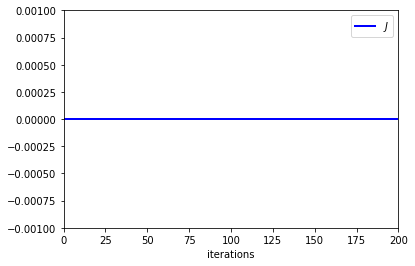

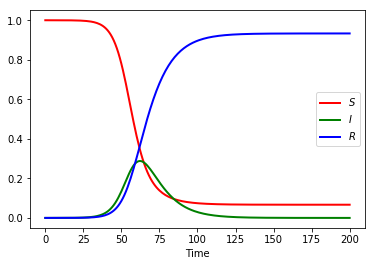

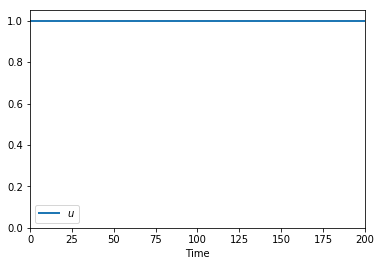

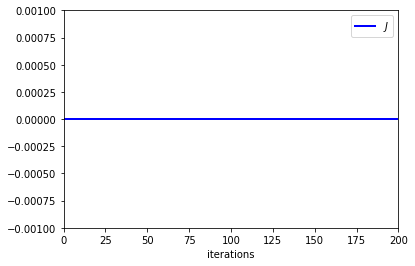

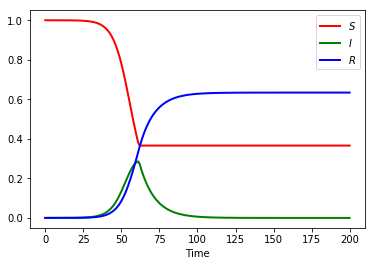

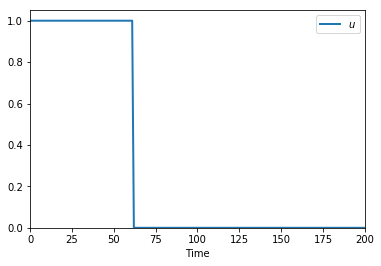

In [6]:
# examples of control (figure 1)
T=200.0
alpha=0.0
# discretisation parameters
NT=int(2e2+1) # number of time step
ITER = 5e4 # number of step in optimisation
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u=np.ones(int(NT))
yval=RK4_state(u,init)
Jval = np.zeros(int(NT))

# plot and save control1
Jval = np.zeros(int(NT))
plot_save_example(Jval,yval,u,tval,'_example1')

# compute the second solution
ind_max_I = np.argmax(yval[:,1])
for i in range(int(ind_max_I),int(NT)):
    u[i]=0.0
yval=RK4_state(u,init)


# plot and save control2
plot_save_example(Jval,yval,u,tval,'_example2')

('i=', 0, 'and J=', 0.9999902220232761, 'rho=', 1000)
('k1=', 1, 'k2=', 1, 'Delta1', -4.2661028268886625e-06, 'Delta2', -4.2661028268886625e-06)
('i=', 1, 'and J=', 0.9999859559204493, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 1, 'Delta1', -0.04169474318444688, 'Delta2', -0.04169474318444688)
('i=', 2, 'and J=', 0.9582912127360024, 'rho=', 4822530.864197532)
('k1=', 60, 'k2=', 20, 'Delta1', -0.002662752959364245, 'Delta2', -0.2374274251947548)
('i=', 3, 'and J=', 0.9556284597766381, 'rho=', 223.24170563467644)
('k1=', 44, 'k2=', 5, 'Delta1', -2.6924837188024853e-05, 'Delta2', -0.0002233785518812592)
('i=', 4, 'and J=', 0.7208368627040596, 'rho=', 2.9437049331690575)
('k1=', 4, 'k2=', 5, 'Delta1', -0.00025951372162968944, 'Delta2', -0.0008364257336193059)
('i=', 5, 'and J=', 0.7203808952677366, 'rho=', 57.050973730462)
('k1=', 23, 'k2=', 5, 'Delta1', -2.408915866780603e-06, 'Delta2', -0.00021645789964486184)
('i=', 6, 'and J=', 0.7198015743398802, 'rho=', 34.60892995463855)
('k1=', 2

('k1=', 20, 'k2=', 4, 'Delta1', -2.7359952303740442e-08, 'Delta2', -6.10841633941206e-08)
('i=', 53, 'and J=', 0.7184601996658493, 'rho=', 1136.2994285728078)
('k1=', 14, 'k2=', 5, 'Delta1', -4.071989079257321e-09, 'Delta2', -4.978215117912299e-08)
('i=', 54, 'and J=', 0.7184601618696491, 'rho=', 3556.715383784037)
('k1=', 27, 'k2=', 4, 'Delta1', -1.1636716257257262e-08, 'Delta2', -4.61310760702105e-08)
('i=', 55, 'and J=', 0.7184601045227708, 'rho=', 1248.6205717166954)
('k1=', 18, 'k2=', 4, 'Delta1', -1.9162849751452882e-08, 'Delta2', -3.7547231990231467e-08)
('i=', 56, 'and J=', 0.7184600508655612, 'rho=', 2261.742052073923)
('k1=', 24, 'k2=', 4, 'Delta1', -1.9552387486854172e-08, 'Delta2', -3.7261255192433396e-08)
('i=', 57, 'and J=', 0.7184600129287915, 'rho=', 1372.0444566906963)
('k1=', 18, 'k2=', 4, 'Delta1', -1.3459693248840665e-08, 'Delta2', -3.8038032168508096e-08)
('i=', 58, 'and J=', 0.7184599817602305, 'rho=', 2485.311162818456)
('k1=', 25, 'k2=', 4, 'Delta1', -2.10840364

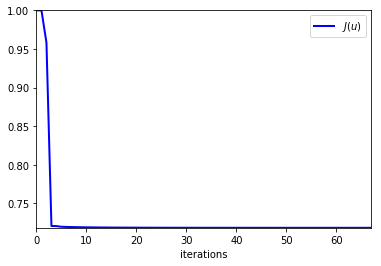

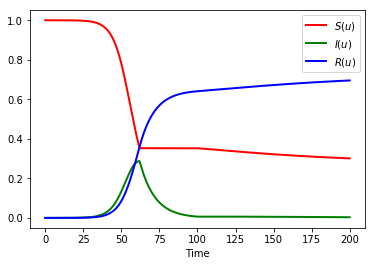

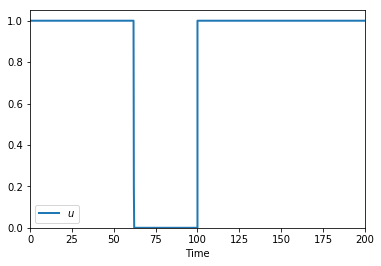

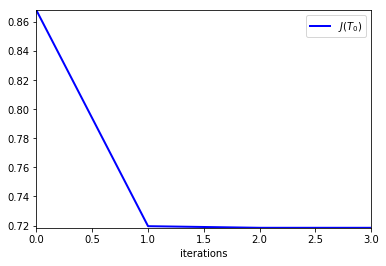

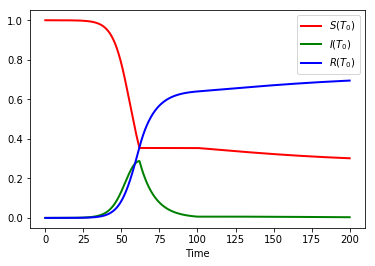

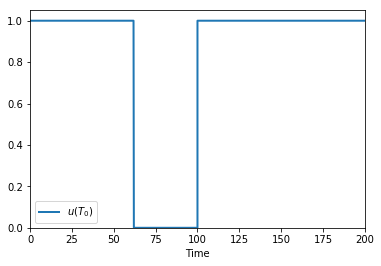

In [15]:
# minimisation with respect to u and T0 for alpha = 0 (figure 3)

# parameters
T=100.0
alpha  = 0.0
NT=int(501) # number of time step
ITER = 5e4 # number of step in optimisation
T_end = 200.0


# optimisation of u
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u=alpha/2*np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval1 = np.concatenate((yval1,y_end),axis=0)
u1 = np.concatenate((u1,u_end),axis=0)



# optimisation of T0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end),axis=0)
u2 = np.concatenate((u2,u_end),axis=0)
T=T_end

    
    
# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)



plot_save_opt_sol(Jval1,yval1,u1,Jval2,yval2,u2,tval)

('i=', 0, 'and J=', 0.9999853222014855, 'rho=', 1000)
('k1=', 1, 'k2=', 1, 'Delta1', -2.8060611976021832e-05, 'Delta2', -2.8060611976021832e-05)
('i=', 1, 'and J=', 0.9999572615895095, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 17, 'Delta1', -0.02398836121858894, 'Delta2', -0.2668900710727603)
('i=', 2, 'and J=', 0.9759689003709205, 'rho=', 260840.53304588856)
('k1=', 75, 'k2=', 5, 'Delta1', -7.035478951866736e-05, 'Delta2', -0.0018662862147866832)
('i=', 3, 'and J=', 0.7329968357272305, 'rho=', 12.074673472413718)
('k1=', 17, 'k2=', 6, 'Delta1', -0.00022030178682130863, 'Delta2', -0.001487916489638641)
('i=', 4, 'and J=', 0.7309806025151412, 'rho=', 18.226645051501407)
('k1=', 22, 'k2=', 5, 'Delta1', -0.00014584202332257323, 'Delta2', -0.0009708088438604712)
('i=', 5, 'and J=', 0.7295671457890013, 'rho=', 13.268233104151024)
('k1=', 16, 'k2=', 6, 'Delta1', -0.00010195270418300595, 'Delta2', -0.0008311926476791687)
('i=', 6, 'and J=', 0.7286402262642804, 'rho=', 24.03397913516568)
('

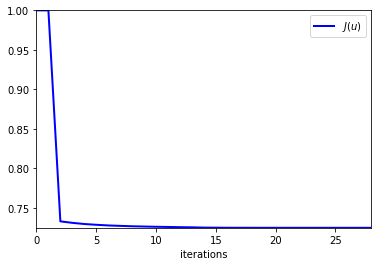

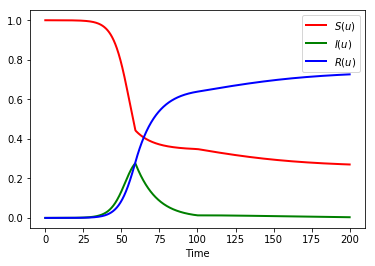

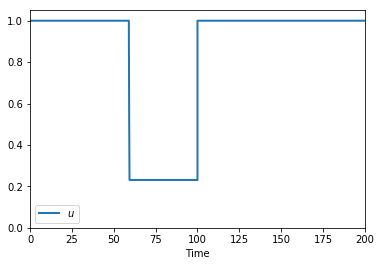

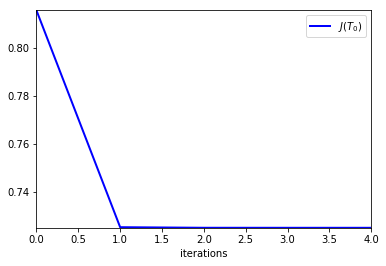

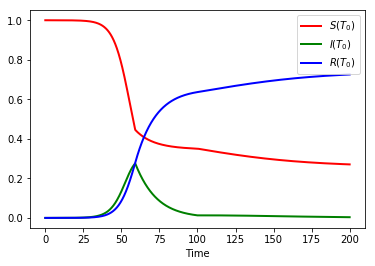

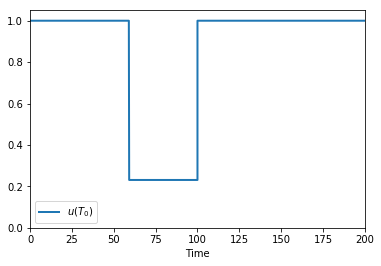

In [16]:
# minimisation with respect to u and T0 for alpha = 0.15625/beta (figure 4)
alpha = alpha_conf
T=100.0 # time of control
T_end = 200.0 # total time of the experiment
NT=int(501) # number of time step
ITER = 5e4 # number of step in optimisation

# optimisation of u
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u=alpha/2*np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval1 = np.concatenate((yval1,y_end),axis=0)
u1 = np.concatenate((u1,u_end),axis=0)


# optimisation of T0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end),axis=0)
u2 = np.concatenate((u2,u_end),axis=0)
T=T_end

    
    
# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)



plot_save_opt_sol(Jval1,yval1,u1,Jval2,yval2,u2,tval)

##############################################
Iteration 1/150 and 1/4
##############################################
('T=', 1.0)
("Nombre d'iterations : ", 57)
(u'le minimiseur trouv\xe9 est x=', 0.00033322223191017996)
('T0=', 0.00033322223191017996)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 1.0000037263817554)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.0667802350001474)
('pour une valeur de ', 1.000003726535645)
##############################################
Iteration 2/150 and 1/4
##############################################
('T=', 3.0067114093959733)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log


("Nombre d'iterations : ", 60)
(u'le minimiseur trouv\xe9 est x=', 0.0010019031427684778)
('T0=', 0.0010019031427684778)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 1.0000012709157258)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.0667808247842537)
('pour une valeur de ', 1.0000012709137014)
##############################################
Iteration 3/150 and 1/4
##############################################
('T=', 5.0134228187919465)
("Nombre d'iterations : ", 61)
(u'le minimiseur trouv\xe9 est x=', 0.7868451008260642)
('T0=', 0.7868451008260642)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.999999172397919)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06678132882245397)
('pour une valeur de ', 0.9999991723242669)
##############################################
Iteration 4/150 and 1/4
##############################################
('T=', 7.02013422818792)
("Nombre d'iterations : ", 62)
(u'le

("Nombre d'iterations : ", 66)
(u'le minimiseur trouv\xe9 est x=', 34.81188597085451)
('T0=', 34.81188597085451)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9962026852408716)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06770095294180872)
('pour une valeur de ', 0.9962026850842454)
##############################################
Iteration 21/150 and 1/4
##############################################
('T=', 41.13422818791946)
("Nombre d'iterations : ", 66)
(u'le minimiseur trouv\xe9 est x=', 36.7891597655114)
('T0=', 36.7891597655114)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9945023766659706)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06811792283832771)
('pour une valeur de ', 0.99450237674768)
##############################################
Iteration 22/150 and 1/4
##############################################
('T=', 43.14093959731544)
("Nombre d'iterations : ", 67)
(u'le minimiseu

("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 59.45144012396392)
('T0=', 59.45144012396392)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7789837589586126)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.17200271153405056)
('pour une valeur de ', 0.7789837589685658)
##############################################
Iteration 39/150 and 1/4
##############################################
('T=', 77.25503355704699)
("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 59.90418630030081)
('T0=', 59.90418630030081)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7682975755764578)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.1833540780453718)
('pour une valeur de ', 0.7682975755799546)
##############################################
Iteration 40/150 and 1/4
##############################################
('T=', 79.26174496644296)
("Nombre d'iterations : ", 68)
(u'le minimi

("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 62.16037607148337)
('T0=', 62.16037607148337)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7140706262592991)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.30814648144236156)
('pour une valeur de ', 0.7140706262584433)
##############################################
Iteration 57/150 and 1/4
##############################################
('T=', 113.37583892617451)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 62.18481535234055)
('T0=', 62.18481535234055)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7136900812930187)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.311515167925571)
('pour une valeur de ', 0.7136900812911229)
##############################################
Iteration 58/150 and 1/4
##############################################
('T=', 115.38255033557047)
("Nombre d'iterations : ", 69)
(u'le minim

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 62.26915860258471)
('T0=', 62.26915860258471)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.712026323261922)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.338590105409445)
('pour une valeur de ', 0.7120263232622531)
##############################################
Iteration 75/150 and 1/4
##############################################
('T=', 149.49664429530202)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 62.269511952372596)
('T0=', 62.269511952372596)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7120159400452533)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3391823392955524)
('pour une valeur de ', 0.7120159400458608)
##############################################
Iteration 76/150 and 1/4
##############################################
('T=', 151.50335570469798)
("Nombre d'iterations : ", 70)
(u'le minim

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 62.28448235372463)
('T0=', 62.28448235372463)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119707939894692)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34378664242906565)
('pour une valeur de ', 0.7119707939894245)
##############################################
Iteration 93/150 and 1/4
##############################################
('T=', 185.61744966442953)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 62.28482899433378)
('T0=', 62.28482899433378)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119705060439416)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3438865484525291)
('pour une valeur de ', 0.7119705060439574)
##############################################
Iteration 94/150 and 1/4
##############################################
('T=', 187.62416107382552)
("Nombre d'iterations : ", 70)
(u'le mini

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.30974462648733)
('T0=', 62.30974462648733)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.71196945294755)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3444266269095885)
('pour une valeur de ', 0.7119694529475458)
##############################################
Iteration 111/150 and 1/4
##############################################
('T=', 221.73825503355707)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.287687102046604)
('T0=', 62.287687102046604)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119693848030813)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34449021014834535)
('pour une valeur de ', 0.7119693848030686)
##############################################
Iteration 112/150 and 1/4
##############################################
('T=', 223.74496644295303)
("Nombre d'iterations : ", 71)
(u'le mi

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.321915066339116)
('T0=', 62.321915066339116)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119692752913069)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3446317367368088)
('pour une valeur de ', 0.7119692752913014)
##############################################
Iteration 129/150 and 1/4
##############################################
('T=', 257.8590604026846)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.29517453910721)
('T0=', 62.29517453910721)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119697524464206)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3442217697437595)
('pour une valeur de ', 0.7119697524463864)
##############################################
Iteration 130/150 and 1/4
##############################################
('T=', 259.86577181208054)
("Nombre d'iterations : ", 71)
(u'le mi

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.36414260119413)
('T0=', 62.36414260119413)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119703676516091)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3439385628986076)
('pour une valeur de ', 0.711970367651684)
##############################################
Iteration 147/150 and 1/4
##############################################
('T=', 293.9798657718121)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 62.3029638889809)
('T0=', 62.3029638889809)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119703991445844)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3439264617266198)
('pour une valeur de ', 0.711970399144617)
##############################################
Iteration 148/150 and 1/4
##############################################
('T=', 295.9865771812081)
("Nombre d'iterations : ", 71)
(u'le minimiseu

("Nombre d'iterations : ", 65)
(u'le minimiseur trouv\xe9 est x=', 22.23122046561796)
('T0=', 22.23122046561796)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9996543032720784)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06686422343622764)
('pour une valeur de ', 0.9996543033086541)
##############################################
Iteration 15/150 and 2/4
##############################################
('T=', 29.093959731543627)
("Nombre d'iterations : ", 66)
(u'le minimiseur trouv\xe9 est x=', 24.236887480431555)
('T0=', 24.236887480431555)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9994920828951394)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06690325974165624)
('pour une valeur de ', 0.9994920830001777)
##############################################
Iteration 16/150 and 2/4
##############################################
('T=', 31.1006711409396)
("Nombre d'iterations : ", 66)
(u'le min

("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 53.68788032621224)
('T0=', 53.68788032621224)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8870973561057311)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.10287438234282209)
('pour une valeur de ', 0.8870973561224476)
##############################################
Iteration 33/150 and 2/4
##############################################
('T=', 65.21476510067114)
("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 54.61003155546163)
('T0=', 54.61003155546163)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8694877601881107)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.11077290404877013)
('pour une valeur de ', 0.8694877602115505)
##############################################
Iteration 34/150 and 2/4
##############################################
('T=', 67.22147651006712)
("Nombre d'iterations : ", 68)
(u'le minim

("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 59.213371829043886)
('T0=', 59.213371829043886)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7256048203947547)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.25672331873873433)
('pour une valeur de ', 0.7256048203937027)
##############################################
Iteration 51/150 and 2/4
##############################################
('T=', 101.33557046979867)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 59.227787605450146)
('T0=', 59.227787605450146)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7236571039116012)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.2626635907779865)
('pour une valeur de ', 0.7236571039148916)
##############################################
Iteration 52/150 and 2/4
##############################################
('T=', 103.34228187919463)
("Nombre d'iterations : ", 69)
(u'le 

("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 59.21691427242319)
('T0=', 59.21691427242319)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.712818217438386)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3211928118453842)
('pour une valeur de ', 0.7128182174390526)
##############################################
Iteration 69/150 and 2/4
##############################################
('T=', 137.4563758389262)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 59.22395666765987)
('T0=', 59.22395666765987)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7126966169688205)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3229122514563517)
('pour une valeur de ', 0.7126966169686026)
##############################################
Iteration 70/150 and 2/4
##############################################
('T=', 139.46308724832215)
("Nombre d'iterations : ", 69)
(u'le minimis

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 59.229259150722285)
('T0=', 59.229259150722285)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7120220345874697)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3388275070806388)
('pour une valeur de ', 0.7120220345873998)
##############################################
Iteration 87/150 and 2/4
##############################################
('T=', 173.5771812080537)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 59.22793520724048)
('T0=', 59.22793520724048)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7120145009729391)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3392694866011754)
('pour une valeur de ', 0.7120145009727296)
##############################################
Iteration 88/150 and 2/4
##############################################
('T=', 175.58389261744966)
("Nombre d'iterations : ", 70)
(u'le mini

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 59.241496682286545)
('T0=', 59.241496682286545)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119725407597959)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34331638651000784)
('pour une valeur de ', 0.7119725407597952)
##############################################
Iteration 105/150 and 2/4
##############################################
('T=', 209.6979865771812)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 59.25487924603863)
('T0=', 59.25487924603863)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119720831002715)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3434242217817569)
('pour une valeur de ', 0.711972083100205)
##############################################
Iteration 106/150 and 2/4
##############################################
('T=', 211.7046979865772)
("Nombre d'iterations : ", 70)
(u'le min

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 59.22659337265311)
('T0=', 59.22659337265311)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119710627842668)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3437013727018675)
('pour une valeur de ', 0.7119710627842367)
##############################################
Iteration 123/150 and 2/4
##############################################
('T=', 245.81879194630875)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 59.3045002895966)
('T0=', 59.3045002895966)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119710295243696)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34371156939947656)
('pour une valeur de ', 0.7119710295242505)
##############################################
Iteration 124/150 and 2/4
##############################################
('T=', 247.8255033557047)
("Nombre d'iterations : ", 71)
(u'le minim

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 59.32599647989754)
('T0=', 59.32599647989754)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119712681619956)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34364035349050215)
('pour une valeur de ', 0.7119712681620992)
##############################################
Iteration 141/150 and 2/4
##############################################
('T=', 281.93959731543623)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 59.28153479038767)
('T0=', 59.28153479038767)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119692377919489)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34471575054340065)
('pour une valeur de ', 0.7119692377919464)
##############################################
Iteration 142/150 and 2/4
##############################################
('T=', 283.94630872483225)
("Nombre d'iterations : ", 71)
(u'le m

("Nombre d'iterations : ", 64)
(u'le minimiseur trouv\xe9 est x=', 7.465829063661779)
('T0=', 7.465829063661779)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9999839004405255)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06678499694881512)
('pour une valeur de ', 0.999983900479763)
##############################################
Iteration 9/150 and 3/4
##############################################
('T=', 17.053691275167786)
("Nombre d'iterations : ", 64)
(u'le minimiseur trouv\xe9 est x=', 9.473010115155395)
('T0=', 9.473010115155395)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9999740426021877)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06678736483646106)
('pour une valeur de ', 0.9999740425900022)
##############################################
Iteration 10/150 and 3/4
##############################################
('T=', 19.06040268456376)
("Nombre d'iterations : ", 65)
(u'le minimi

("Nombre d'iterations : ", 67)
(u'le minimiseur trouv\xe9 est x=', 42.301657836611355)
('T0=', 42.301657836611355)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9835624597713144)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07087891507925917)
('pour une valeur de ', 0.9835624596469547)
##############################################
Iteration 27/150 and 3/4
##############################################
('T=', 53.1744966442953)
("Nombre d'iterations : ", 67)
(u'le minimiseur trouv\xe9 est x=', 43.801184839939864)
('T0=', 43.801184839939864)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.977770259339803)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07239772990378071)
('pour une valeur de ', 0.9777702592148836)
##############################################
Iteration 28/150 and 3/4
##############################################
('T=', 55.18120805369128)
("Nombre d'iterations : ", 67)
(u'le min

("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 48.42902477693487)
('T0=', 48.42902477693487)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8222303240364746)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13713795928573558)
('pour une valeur de ', 0.8222303240287783)
##############################################
Iteration 45/150 and 3/4
##############################################
('T=', 89.29530201342283)
("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 48.02486419514004)
('T0=', 48.02486419514004)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8168516600972737)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.14076788568515974)
('pour une valeur de ', 0.8168516601320196)
##############################################
Iteration 46/150 and 3/4
##############################################
('T=', 91.3020134228188)
("Nombre d'iterations : ", 68)
(u'le minimi

("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 39.806829490809605)
('T0=', 39.806829490809605)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7713705365545829)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.17993370123239683)
('pour une valeur de ', 0.7713705365522149)
##############################################
Iteration 63/150 and 3/4
##############################################
('T=', 125.41610738255034)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 39.28395232905457)
('T0=', 39.28395232905457)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7702584697675762)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.18115583899559384)
('pour une valeur de ', 0.7702584697641215)
##############################################
Iteration 64/150 and 3/4
##############################################
('T=', 127.42281879194631)
("Nombre d'iterations : ", 69)
(u'le m

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 30.406956070551352)
('T0=', 30.406956070551352)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7609826548291733)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19209111354249564)
('pour une valeur de ', 0.7609826548586877)
##############################################
Iteration 81/150 and 3/4
##############################################
('T=', 161.53691275167785)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 29.928198430473742)
('T0=', 29.928198430473742)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7607652998083573)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19236491322677968)
('pour une valeur de ', 0.7607652998016026)
##############################################
Iteration 82/150 and 3/4
##############################################
('T=', 163.54362416107384)
("Nombre d'iterations : ", 70)
(u'le

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 21.253658176555994)
('T0=', 21.253658176555994)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7590013477144864)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19462019265308206)
('pour une valeur de ', 0.7590013477204053)
##############################################
Iteration 99/150 and 3/4
##############################################
('T=', 197.65771812080538)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 20.74714468776797)
('T0=', 20.74714468776797)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7589613551048845)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19467202597297734)
('pour une valeur de ', 0.7589613551170737)
##############################################
Iteration 100/150 and 3/4
##############################################
('T=', 199.66442953020135)
("Nombre d'iterations : ", 70)
(u'le 

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 12.202581242472359)
('T0=', 12.202581242472359)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7586399521669137)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19508974261357098)
('pour une valeur de ', 0.7586399521843727)
##############################################
Iteration 117/150 and 3/4
##############################################
('T=', 233.7785234899329)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 11.685031164074175)
('T0=', 11.685031164074175)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.758632739058473)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19509914094293168)
('pour une valeur de ', 0.7586327390552063)
##############################################
Iteration 118/150 and 3/4
##############################################
('T=', 235.78523489932888)
("Nombre d'iterations : ", 71)
(u'le

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 3.1243724127365518)
('T0=', 3.1243724127365518)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7585749174080797)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.19517451721436252)
('pour une valeur de ', 0.7585749174153015)
##############################################
Iteration 135/150 and 3/4
##############################################
('T=', 269.8993288590604)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 2.6980939239245476)
('T0=', 2.6980939239245476)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7585736230482382)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.1951762053168154)
('pour une valeur de ', 0.7585736230496276)
##############################################
Iteration 136/150 and 3/4
##############################################
('T=', 271.90604026845637)
("Nombre d'iterations : ", 71)
(u'le

("Nombre d'iterations : ", 60)
(u'le minimiseur trouv\xe9 est x=', 0.0010019031427684778)
('T0=', 0.0010019031427684778)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 1.0000040449937477)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06678015848718072)
('pour une valeur de ', 1.000004045106594)
##############################################
Iteration 3/150 and 4/4
##############################################
('T=', 5.0134228187919465)
("Nombre d'iterations : ", 61)
(u'le minimiseur trouv\xe9 est x=', 0.0016705840576538807)
('T0=', 0.0016705840576538807)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 1.0000030250317475)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06678040352136155)
('pour une valeur de ', 1.0000030248788765)
##############################################
Iteration 4/150 and 4/4
##############################################
('T=', 7.02013422818792)
("Nombre d'iterations : ", 62

("Nombre d'iterations : ", 66)
(u'le minimiseur trouv\xe9 est x=', 29.974728781636387)
('T0=', 29.974728781636387)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9984647807896969)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.0671511250628351)
('pour une valeur de ', 0.9984647808147817)
##############################################
Iteration 21/150 and 4/4
##############################################
('T=', 41.13422818791946)
("Nombre d'iterations : ", 66)
(u'le minimiseur trouv\xe9 est x=', 31.909524565610326)
('T0=', 31.909524565610326)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9977750746910449)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.06731817583103888)
('pour une valeur de ', 0.9977750748002234)
##############################################
Iteration 22/150 and 4/4
##############################################
('T=', 43.14093959731544)
("Nombre d'iterations : ", 67)
(u'le mi

("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 46.73871125728347)
('T0=', 46.73871125728347)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8976669073616117)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.09851581742184176)
('pour une valeur de ', 0.8976669073298754)
##############################################
Iteration 39/150 and 4/4
##############################################
('T=', 77.25503355704699)
("Nombre d'iterations : ", 68)
(u'le minimiseur trouv\xe9 est x=', 46.414803566570555)
('T0=', 46.414803566570555)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8909319138906946)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.10126218797863815)
('pour une valeur de ', 0.890931913889786)
##############################################
Iteration 40/150 and 4/4
##############################################
('T=', 79.26174496644296)
("Nombre d'iterations : ", 68)
(u'le mini

("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 36.73956555865287)
('T0=', 36.73956555865287)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8366785587225208)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.12811350383281966)
('pour une valeur de ', 0.8366785587631542)
##############################################
Iteration 57/150 and 4/4
##############################################
('T=', 113.37583892617451)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 36.07928229737563)
('T0=', 36.07928229737563)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8356033982516569)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.12875162004814328)
('pour une valeur de ', 0.835603398192714)
##############################################
Iteration 58/150 and 4/4
##############################################
('T=', 115.38255033557047)
("Nombre d'iterations : ", 69)
(u'le mini

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 25.261521327314615)
('T0=', 25.261521327314615)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.828022332371203)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13339964789338404)
('pour une valeur de ', 0.8280223323706175)
##############################################
Iteration 75/150 and 4/4
##############################################
('T=', 149.49664429530202)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 24.608911123550676)
('T0=', 24.608911123550676)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8278894010851273)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13348356342938694)
('pour une valeur de ', 0.8278894010503847)
##############################################
Iteration 76/150 and 4/4
##############################################
('T=', 151.50335570469798)
("Nombre d'iterations : ", 70)
(u'le 

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 13.888583000297128)
('T0=', 13.888583000297128)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8269737764015157)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13406391877777363)
('pour une valeur de ', 0.8269737763495144)
##############################################
Iteration 93/150 and 4/4
##############################################
('T=', 185.61744966442953)
("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 13.29815117551787)
('T0=', 13.29815117551787)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8269580923927738)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13407389573142703)
('pour une valeur de ', 0.8269580924029781)
##############################################
Iteration 94/150 and 4/4
##############################################
('T=', 187.62416107382552)
("Nombre d'iterations : ", 70)
(u'le m

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 2.6358998901661934)
('T0=', 2.6358998901661934)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8268504761487556)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13414238591614208)
('pour une valeur de ', 0.8268504761601312)
##############################################
Iteration 111/150 and 4/4
##############################################
('T=', 221.73825503355707)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 1.9949793021731894)
('T0=', 1.9949793021731894)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8268486395826249)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13414355528797828)
('pour une valeur de ', 0.8268486395476369)
##############################################
Iteration 112/150 and 4/4
##############################################
('T=', 223.74496644295303)
("Nombre d'iterations : ", 71)
(u'

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 0.08458701685000067)
('T0=', 0.08458701685000067)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8268369786544979)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.1341509801769179)
('pour une valeur de ', 0.8268369786469452)
##############################################
Iteration 128/150 and 4/4
##############################################
('T=', 255.85234899328862)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 0.08525569775945127)
('T0=', 0.08525569775945127)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.826836791333733)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13415109948255122)
('pour une valeur de ', 0.8268367912842618)
##############################################
Iteration 129/150 and 4/4
##############################################
('T=', 257.8590604026846)
("Nombre d'iterations : ", 71)
(u

("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 0.09595459231066095)
('T0=', 0.09595459231066095)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8268356659910381)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13415181603892862)
('pour une valeur de ', 0.8268356659791334)
##############################################
Iteration 145/150 and 4/4
##############################################
('T=', 289.96644295302013)
("Nombre d'iterations : ", 71)
(u'le minimiseur trouv\xe9 est x=', 0.09662327322011152)
('T0=', 0.09662327322011152)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8268356481203465)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.13415182743960152)
('pour une valeur de ', 0.8268356480751986)
##############################################
Iteration 146/150 and 4/4
##############################################
('T=', 291.9731543624161)
("Nombre d'iterations : ", 71)


('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9839648117155058)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07077491043360326)
('pour une valeur de ', 0.9839648116384089)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9775807016046741)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07244812665860459)
('pour une valeur de ', 0.9775807016840651)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9691667737588866)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07473066950955527)
('pour une valeur de ', 0.9691667736590147)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9584451589307658)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07777417403774273)
('pour une valeur de ', 0.9584451589166552)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9453087046547537)
("Nombre d'iterations : ", 32

('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7126039903438535)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3243255865326601)
('pour une valeur de ', 0.712603990344647)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7124889044262387)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3262409037541085)
('pour une valeur de ', 0.7124889044256197)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7123937242169107)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3279991286951278)
('pour une valeur de ', 0.7123937242188572)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7123182860543964)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.32954376756920123)
('pour une valeur de ', 0.7123182860537496)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7122556513349731)
("Nombre d'iterations : ", 32)
('

('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119770700972592)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3425059950476963)
('pour une valeur de ', 0.711977070097404)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119737648795579)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34306012379037676)
('pour une valeur de ', 0.7119737648796028)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119727241606328)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3432752827487501)
('pour une valeur de ', 0.7119727241607041)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119733026293305)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3431522588101056)
('pour une valeur de ', 0.7119733026292892)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119759070400715)
("Nombre d'iterations : ", 32)
('

('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119769687450643)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34252099640635336)
('pour une valeur de ', 0.7119769687451871)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119793248868574)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3421944083148164)
('pour une valeur de ', 0.7119793248866912)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119837116126784)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34167583931462264)
('pour une valeur de ', 0.7119837116124161)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119910092332725)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3409655932096186)
('pour une valeur de ', 0.7119910092330232)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119753165130153)
("Nombre d'iterations : ", 32)


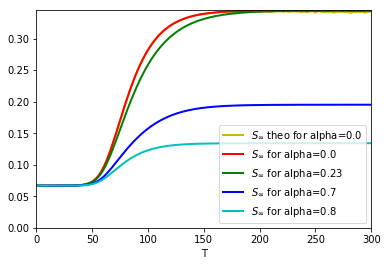

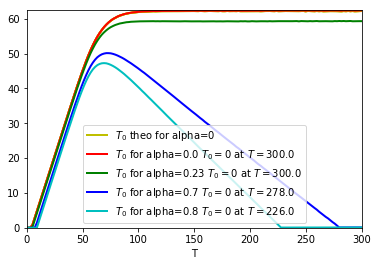

In [17]:
#graphique S infini et T0 en fonction de T (figure 5)

# parameters
min_T=1
max_T=300
nb_T = 150
Time = np.linspace(min_T,max_T,nb_T)
alpha_array=[0.0,alpha_conf,0.7,0.8]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']
NT=int(3001) # number of time step
#ITER = 5e4 # number of step in optimisation

S_inf_array =  np.zeros((len(Time),len(alpha_array)))
T0_array =  np.zeros((len(Time),len(alpha_array)))
min_zero =  np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        T0init = T/2
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        val = yval[-1,0]+yval[-1,1]-(nu/beta)*np.log(yval[-1,0])
        S_inf = Dicho_S_inf(val)
        S_inf_array[ind_T,ind_alpha] = S_inf[-1]
        T0_array[ind_T,ind_alpha] = T0
    ind_T = nb_T-1
    min_zero[ind_alpha] = max_T
    while T0_array[ind_T,ind_alpha]<=1 and ind_T>=0:
        min_zero[ind_alpha] = Time[ind_T]
        ind_T=ind_T-1

        
# computation of the theoretical T0
NT=int(10001) # number of time step
T0_theo_array =  np.zeros((len(Time),len(alpha_array)))
S_inf_theo_array =  np.zeros((len(Time),len(alpha_array)))
for ind_T in range(len(Time)):
    T = Time[ind_T]
    tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
    h = (T-t0)/(NT-1)        #the time step
    u=np.ones(int(NT))
    yval = RK4_state(u,init) 
    Sherd = nu/beta
    T0_ind = int(NT-1)
    while yval[T0_ind,0]*(1-np.exp(nu*(tval[T0_ind]-T)))<=Sherd and T0_ind >= 1:
        T0_ind -= 1
    T0_theo_array[ind_T] = tval[T0_ind]
    for ind in range(T0_ind,NT):
        u[ind]=0
    yval = RK4_state(u,init) 
    J_value = yval[-1,0]+yval[-1,1]-(nu/beta)*np.log(yval[-1,0])
    S_inf = Dicho_S_inf(J_value)
    S_inf_theo_array[ind_T] = S_inf[-1]


# post processing - resultats et figures
# Plot
plt.figure(1)
plt.plot(Time,S_inf_theo_array[:,ind_alpha],'y-',linewidth=2,label=r'$S_\infty$ theo for alpha=0.0')
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,S_inf_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time),0.0, max(np.max(S_inf_array),np.max(S_inf_theo_array))])
plt.savefig("simu_covid_S_infinity_with_respect_to_T.png")
plt.figure(2)
plt.plot(Time,T0_theo_array,'y-',linewidth=2,label=r'$T_0$ theo for alpha=0')
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,T0_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T_0$ for alpha={0} $T_0=0$ at $T=${1}'.format(round(alpha_array[ind_alpha],2),round(min_zero[ind_alpha],0)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time), 0.0, np.max(T0_array)])
plt.savefig("simu_covid_T0_with_respect_to_T.png")
plt.show()

# Save the values for tikz
File = open('simu_covid_S_infinity_with_respect_to_T.txt','w')
File.write('\\addplot[color=red,opacity = 0.25,line width=1mm]')
File.write(' coordinates { ')
write_to_file(File,Time,S_inf_theo_array[:,ind_alpha])
File.write(' };\n\n')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,S_inf_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('simu_covid_T0_with_respect_to_T.txt','w')
File.write('\\addplot[color=red,opacity = 0.25,line width=1mm]')
File.write(' coordinates { ')
write_to_file(File,Time,T0_theo_array[:,ind_alpha])
File.write(' };\n\n')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,T0_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()


##############################################
Iteration T: 1/3 and alpha: 1/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9 est x=', 61.9666666666443)
('T0=', 61.9666666666443)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.718459362651602)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.2821799411422349)
('pour une valeur de ', 0.7184593626524034)
##############################################
Iteration T: 2/3 and alpha: 1/100
##############################################
('T=', 200)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log


("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 62.266666666619955)
('T0=', 62.266666666619955)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119700296455173)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34408072005668333)
('pour une valeur de ', 0.7119700296454723)
##############################################
Iteration T: 3/3 and alpha: 1/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 62.399999999973446)
('T0=', 62.399999999973446)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.711969412570401)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34446295900752066)
('pour une valeur de ', 0.7119694125704121)
##############################################
Iteration T: 1/3 and alpha: 2/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur t

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 61.66666666662766)
('T0=', 61.66666666662766)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119702455287409)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3439871393192303)
('pour une valeur de ', 0.7119702455287177)
##############################################
Iteration T: 3/3 and alpha: 7/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 61.7333333333294)
('T0=', 61.7333333333294)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119695097792009)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.344380468395057)
('pour une valeur de ', 0.7119695097791717)
##############################################
Iteration T: 1/3 and alpha: 8/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv\xe9

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 60.933333333331504)
('T0=', 60.933333333331504)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119708101265367)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3437813265040388)
('pour une valeur de ', 0.711970810126618)
##############################################
Iteration T: 3/3 and alpha: 13/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 61.066666666648075)
('T0=', 61.066666666648075)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119717412734197)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3435105367579723)
('pour une valeur de ', 0.711971741273315)
##############################################
Iteration T: 1/3 and alpha: 14/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur tr

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 60.06666666666092)
('T0=', 60.06666666666092)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119723925108079)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34335045156004873)
('pour une valeur de ', 0.7119723925106405)
##############################################
Iteration T: 3/3 and alpha: 19/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 60.133333333292384)
('T0=', 60.133333333292384)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119714516442739)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3435883865739894)
('pour une valeur de ', 0.7119714516443494)
##############################################
Iteration T: 1/3 and alpha: 20/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur t

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 59.06666666662424)
('T0=', 59.06666666662424)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119761894695844)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3426397955125391)
('pour une valeur de ', 0.7119761894694128)
##############################################
Iteration T: 3/3 and alpha: 25/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 59.19999999997063)
('T0=', 59.19999999997063)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119695637762031)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3443406537929872)
('pour une valeur de ', 0.7119695637761634)
##############################################
Iteration T: 1/3 and alpha: 26/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur trou

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 57.86666666662208)
('T0=', 57.86666666662208)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119842570567467)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34161725808095567)
('pour une valeur de ', 0.7119842570566826)
##############################################
Iteration T: 3/3 and alpha: 31/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 57.99999999998204)
('T0=', 57.99999999998204)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119697823300382)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3442050219144158)
('pour une valeur de ', 0.7119697823300484)
##############################################
Iteration T: 1/3 and alpha: 32/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur tro

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 56.3333333333203)
('T0=', 56.3333333333203)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7120039301517332)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.33995802341639214)
('pour une valeur de ', 0.7120039301521965)
##############################################
Iteration T: 3/3 and alpha: 37/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 56.39999999997892)
('T0=', 56.39999999997892)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119718578468168)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34348047663586156)
('pour une valeur de ', 0.7119718578468321)
##############################################
Iteration T: 1/3 and alpha: 38/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur trou

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 54.33333333330653)
('T0=', 54.33333333330653)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7120502355221147)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.33740667365330823)
('pour une valeur de ', 0.7120502355214694)
##############################################
Iteration T: 3/3 and alpha: 43/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 54.399999999975435)
('T0=', 54.399999999975435)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.711969246206583)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3446922779227768)
('pour une valeur de ', 0.7119692462065892)
##############################################
Iteration T: 1/3 and alpha: 44/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur tr

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 51.26666666665973)
('T0=', 51.26666666665973)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7121805231248457)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.33289631776479556)
('pour une valeur de ', 0.7121805231259528)
##############################################
Iteration T: 3/3 and alpha: 49/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 51.1999999999975)
('T0=', 51.1999999999975)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119702189249106)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3439980996210642)
('pour une valeur de ', 0.7119702189249848)
##############################################
Iteration T: 1/3 and alpha: 50/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur trouv

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 44.99999999998744)
('T0=', 44.99999999998744)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7127058738433439)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.3227763061395622)
('pour une valeur de ', 0.7127058738412768)
##############################################
Iteration T: 3/3 and alpha: 55/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 43.73333333329245)
('T0=', 43.73333333329245)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7119693401697769)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.34453936928786855)
('pour une valeur de ', 0.7119693401697598)
##############################################
Iteration T: 1/3 and alpha: 56/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur tro

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 33.066666666653916)
('T0=', 33.066666666653916)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7182093735786663)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.2833185620718347)
('pour une valeur de ', 0.7182093735852881)
##############################################
Iteration T: 3/3 and alpha: 61/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7165847382280214)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.29144260795497945)
('pour une valeur de ', 0.716584738233484)
##############################################
Iteration T: 1/3 and alpha: 62/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseu

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 24.86666666663234)
('T0=', 24.86666666663234)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7383449150732753)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.22693691987961784)
('pour une valeur de ', 0.7383449150903332)
##############################################
Iteration T: 3/3 and alpha: 67/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7376335204070446)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.22831859175469088)
('pour une valeur de ', 0.7376335204203817)
##############################################
Iteration T: 1/3 and alpha: 68/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseu

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 17.866666666627772)
('T0=', 17.866666666627772)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7708652576786669)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.18048684044484176)
('pour une valeur de ', 0.770865257682684)
##############################################
Iteration T: 3/3 and alpha: 73/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.7706177086023411)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.18075914118149927)
('pour une valeur de ', 0.7706177086310897)
##############################################
Iteration T: 1/3 and alpha: 74/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimise

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 11.066666666628667)
('T0=', 11.066666666628667)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8118404681995355)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.1442983760578751)
('pour une valeur de ', 0.811840468194364)
##############################################
Iteration T: 3/3 and alpha: 79/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8117630497406758)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.14435410391186076)
('pour une valeur de ', 0.8117630497707555)
##############################################
Iteration T: 1/3 and alpha: 80/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseu

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 4.066666666622252)
('T0=', 4.066666666622252)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8586055738321191)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.1161065160152342)
('pour une valeur de ', 0.8586055738397065)
##############################################
Iteration T: 3/3 and alpha: 85/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.8585839460526334)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.11611749582667033)
('pour une valeur de ', 0.8585839459819586)
##############################################
Iteration T: 1/3 and alpha: 86/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minimiseur

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 0.06666666664209947)
('T0=', 0.06666666664209947)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9094074912959467)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.09397141727747332)
('pour une valeur de ', 0.9094074912317809)
##############################################
Iteration T: 3/3 and alpha: 91/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9094024762961792)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.09397329589962192)
('pour une valeur de ', 0.9094024763294459)
##############################################
Iteration T: 1/3 and alpha: 92/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minim

("Nombre d'iterations : ", 70)
(u'le minimiseur trouv\xe9 est x=', 0.06666666664209947)
('T0=', 0.06666666664209947)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9630637270509581)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07644396303382156)
('pour une valeur de ', 0.9630637271467613)
##############################################
Iteration T: 3/3 and alpha: 97/100
##############################################
('T=', 400)
("Nombre d'iterations : ", 72)
(u'le minimiseur trouv\xe9 est x=', 0.13333333329467983)
('T0=', 0.13333333329467983)
('J(S_inf_min)', 0.7119692196525615)
('J(S_inf_max)', inf)
('val', 0.9630629144685173)
("Nombre d'iterations : ", 32)
('le minimiseur trouv\\u00e9 est x=', 0.07644419449959593)
('pour une valeur de ', 0.9630629145057122)
##############################################
Iteration T: 1/3 and alpha: 98/100
##############################################
('T=', 100)
("Nombre d'iterations : ", 69)
(u'le minim

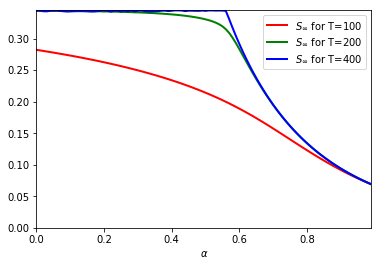

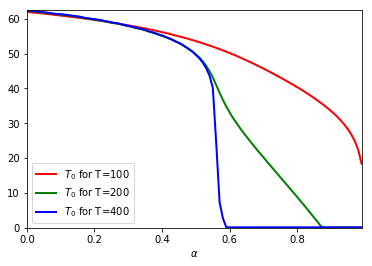

In [20]:
#graphique S infini et T0 en fonction de alpha (figure 6)

# parameters
nb_alpha = 100
min_alpha = 0
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
Time=[100,200,400]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']
NT=int(3e3) # number of time step
#ITER = 5e4 # number of step in optimisation

S_inf_array =  np.zeros((len(alpha_array),len(Time)))
T0_array =  np.zeros((len(alpha_array),len(Time)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration T: '+str(ind_T+1)+'/'+str(len(Time))+' and alpha: '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        T0init = T/2
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        val = yval[-1,0]+yval[-1,1]-(nu/beta)*np.log(yval[-1,0])
        S_inf = Dicho_S_inf(val)
        S_inf_array[ind_alpha,ind_T] = S_inf[-1]
        T0_array[ind_alpha,ind_T] = T0
    

# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,S_inf_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$S_\infty$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_array)])
plt.savefig("simu_covid_S_infinity_with_respect_to_alpha.png")
plt.figure(2)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,T0_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$T_0$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T0_array)])
plt.savefig("simu_covid_T0_with_respect_to_alpha.png")
plt.show()

# Save the values for tikz
File = open('simu_covid_S_infinity_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,S_inf_array[:,ind_T])
    File.write(' };\n\n')
File.close()
File = open('simu_covid_T0_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,T0_array[:,ind_T])
    File.write(' };\n\n')
File.close()


Argmin de J pour T=200: [54.545 52.525 48.485 22.222  2.02   0.   ]
Argmin de J pour T=300: [54.545 54.545 48.485  3.03   0.     0.   ]


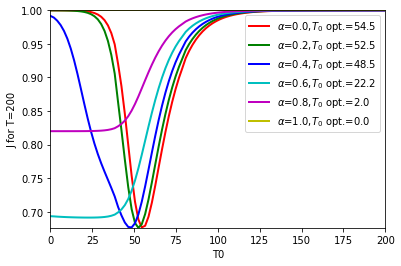

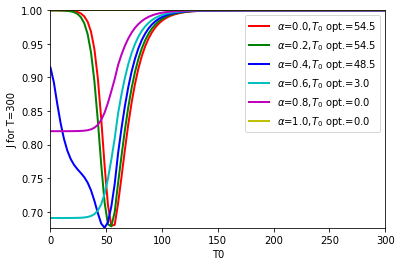

In [55]:
# calcul de J pour toute les valeurs de T0

# parameters
NT=int(5e2) # number of time step
ITER = 5e4 # number of step in optimisation
alpha_array = np.linspace(0,1,6)
color=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','yellow','brown','black']

T=200
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]
    

# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("simu_covid_values_J_T_{0}.png".format(T))

# Save the values for tikz
File = open('simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

T=300
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]


# Plot
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("simu_covid_values_J_T_{0}.png".format(T))


# Save the values for tikz
File = open('simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

plt.show()




[300.         300.         263.45269054 210.46209242 176.19523905
 148.70974195]


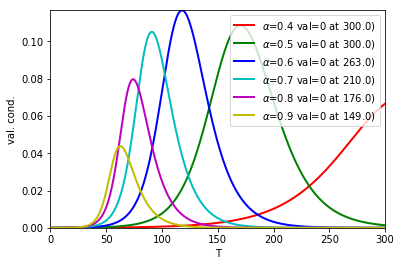

In [69]:
# vérification de la condition de Nicolas


color=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','yellow','brown','black']
alpha_array=np.linspace(0.4,0.9,6)
T=300
NT=int(5e3)
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)
val_array = np.zeros((len(tval),len(alpha_array)))
min_zero = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    u=alpha*np.ones(int(NT))
    yval=RK4_state(u,init)
    for ind_T in range(len(tval)):
        val_array[ind_T,ind_alpha] = (1-alpha)*yval[ind_T,1]*(1+h*nu*I0*sum(yval[:ind_T,1]**(-1)))
    ind_T = len(tval)-1
    min_zero[ind_alpha] = T
    while val_array[ind_T,ind_alpha]<=1e-4 and ind_T>=0:
        min_zero[ind_alpha] = tval[ind_T]
        ind_T=ind_T-1

print(min_zero)
        
# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(tval,val_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0} val=0 at {1})'.format(alpha_array[ind_alpha],round(min_zero[ind_alpha],0)))
plt.legend(loc='best')
plt.xlabel('T')
plt.ylabel('val. cond.')
plt.axis([0,T,np.min(val_array),np.max(val_array)])
plt.savefig("simu_covid_cond_nicolas.png")

# Save the values for tikz
File = open('simu_covid_cond_nicolas.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,tval,val_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

